#### **F1 Forecasting Model**

#### **Library Imports**

In [692]:
import os
import datetime
import requests
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from datetime import date, datetime, timedelta
from scipy import stats
from pyergast import pyergast

### **File Imports**

In [628]:
dir_path = "/Users/sharvarideshpande/Desktop/zapata/data_files" #Change this to the directory where the files are stored

lap_times = pd.read_csv(f'{dir_path}/lap_times.csv')
pit_stops = pd.read_csv(f'{dir_path}/pit_stops.csv')
qualifying = pd.read_csv(f'{dir_path}/qualifying.csv')
races = pd.read_csv(f'{dir_path}/races.csv')
results = pd.read_csv(f'{dir_path}/results.csv')
sprint_results = pd.read_csv(f'{dir_path}/sprint_results.csv')
status = pd.read_csv(f'{dir_path}/status.csv')

#### **Data Preprocessing**

##### Handling \N values

In [630]:
def check_for_N_values(df, df_name):
    cols = []
    for column in df.columns:
        if df[column].astype(str).str.contains(r'\\N').any():
            cols.append(column)
    if cols:
        print("------------------------------------------------------------------------")
        print(f"Columns '{cols}' in dataframe {df_name} contains '\\N' values.")
    
    return cols

dataframes = [lap_times, qualifying, sprint_results, pit_stops, results, races, status]
dataframe_names = ['lap_times', 'qualifying', 'sprint_results', 'pit_stops', 'results', 'races', 'status']

for df, name in zip(dataframes, dataframe_names):
    column_names = check_for_N_values(df, name)
    if column_names:
        for col in column_names:
            df[col].replace('\\N', np.nan, inplace=True)
        print(f"All values in {name} have been filled with np.nan")

------------------------------------------------------------------------
Columns '['q1', 'q2', 'q3']' in dataframe qualifying contains '\N' values.
All values in qualifying have been filled with np.nan
------------------------------------------------------------------------
Columns '['position', 'time', 'milliseconds', 'fastestLap', 'fastestLapTime']' in dataframe sprint_results contains '\N' values.
All values in sprint_results have been filled with np.nan
------------------------------------------------------------------------
Columns '['number', 'position', 'time', 'milliseconds', 'fastestLap', 'rank', 'fastestLapTime', 'fastestLapSpeed']' in dataframe results contains '\N' values.
All values in results have been filled with np.nan
------------------------------------------------------------------------
Columns '['time', 'fp1_date', 'fp1_time', 'fp2_date', 'fp2_time', 'fp3_date', 'fp3_time', 'quali_date', 'quali_time', 'sprint_date', 'sprint_time']' in dataframe races contains '\N' 

##### Processing Time Features

In [631]:
def time_conversion(time_str):
        try:
            if '.' in time_str:
                time_parts = time_str.split('.')
                time_without_ms = time_parts[0]
                ms = int(time_parts[1])
            else:
                time_without_ms = time_str
                ms = 0

            if ':' in time_without_ms:
                parts = time_without_ms.split(':')
                if len(parts) == 3:
                    hours = int(parts[0])
                    minutes = int(parts[1])
                    seconds = float(parts[2])
                elif len(parts) == 2:
                    hours = 0
                    minutes = int(parts[0])
                    seconds = float(parts[1])
                else:
                    return None
            else:
                seconds = float(time_without_ms)
                minutes = 0
                hours = 0
            
            total_seconds = hours * 3600 + minutes * 60 + seconds
            milliseconds = int(total_seconds * 1000 + ms)
            
            return milliseconds
        except ValueError:
            print(f"Error converting time string: {time_str}")
            return None

def convert_to_timedelta(lap_time_str):
    parts = lap_time_str.split(':')
    if len(parts) == 3:
        # Format is hours:minutes:seconds.milliseconds
        hours, minutes, seconds_milliseconds = parts
    elif len(parts) == 2:
        # Format is minutes:seconds.milliseconds
        hours = 0
        minutes, seconds_milliseconds = parts
    else:
        raise ValueError(f"Invalid time format: {lap_time_str}")

    seconds, milliseconds = seconds_milliseconds.split('.')
    
    return timedelta(hours=int(hours), minutes=int(minutes), seconds=int(seconds), milliseconds=int(milliseconds))


#### lap_times dataframe preprocessing

In [632]:
lap_times.head()

,raceId,driverId,lap,position,time,milliseconds
0,841,20,1,1,1:38.109,98109
1,841,20,2,1,1:33.006,93006
2,841,20,3,1,1:32.713,92713
3,841,20,4,1,1:32.803,92803
4,841,20,5,1,1:32.342,92342


In [633]:
lap_times.isna().sum()

raceId          0
driverId        0
lap             0
position        0
time            0
milliseconds    0
dtype: int64

In [634]:
lap_times.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
raceId,551742.0,NaN,NaN,NaN,564.9,425.9,1.0,131.0,846.0,976.0,1110.0
driverId,551742.0,NaN,NaN,NaN,296.9,377.9,1.0,15.0,39.0,817.0,858.0
lap,551742.0,NaN,NaN,NaN,30.0,18.4,1.0,14.0,29.0,44.0,87.0
position,551742.0,NaN,NaN,NaN,9.7,5.5,1.0,5.0,9.0,14.0,24.0
time,551742,74802,1:21.571,43,NaN,NaN,NaN,NaN,NaN,NaN,NaN
milliseconds,551742.0,NaN,NaN,NaN,95706.2,74786.0,55404.0,81993.0,90673.0,102243.0,7507547.0


Text(0.5, 1.0, 'Lap distribution')

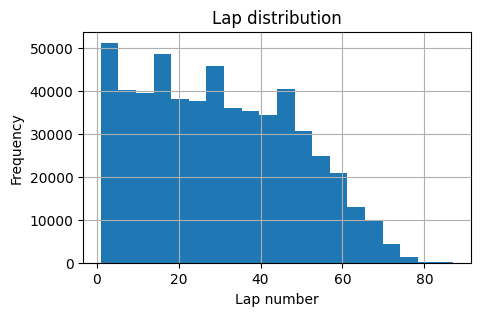

In [635]:
# There are 87 laps across races with majority of races having a median of 29 laps.
# The maximum number of laps in a single race is 87.

plt.figure(figsize=(5, 3))
lap_times["lap"].hist(bins=20)
plt.xlabel("Lap number")
plt.ylabel("Frequency")
plt.title("Lap distribution")

In [636]:
# Aggregate the data
# Calculate total time for each driver in each race
driver_race_times = lap_times.groupby(['raceId', 'driverId'])['milliseconds'].sum().reset_index()
driver_race_times.columns = ['raceId', 'driverId', 'total_time']

# Find the minimum position each driver achieved in each race
driver_race_positions = lap_times.groupby(['raceId', 'driverId'])['position'].min().reset_index()
driver_race_positions.columns = ['raceId', 'driverId', 'best_position']

# Merge the two dataframes
driver_race_stats = pd.merge(driver_race_times, driver_race_positions, on=['raceId', 'driverId'])

# Find the top drivers by position and time for each race
top_drivers_per_race = driver_race_stats.sort_values(by=['raceId', 'best_position', 'total_time']).groupby('raceId').head(10)

# Display the results
print("Top Drivers by Position and Time in Every Race:")
print(top_drivers_per_race.head(2))


Top Drivers by Position and Time in Every Race:
    raceId  driverId  total_time  best_position
14       1        18     5655784              1
15       1        20     5394225              2


In [637]:
def get_top_k_drivers_across_races(lap_times, k=10):
    driver_race_positions = lap_times.groupby(['raceId', 'driverId'])['position'].min().reset_index()
    driver_race_positions.columns = ['raceId', 'driverId', 'best_position']

    top_positions = driver_race_positions.groupby('driverId')['best_position'].min().nsmallest(10).index

    lap_times['is_top_10_driver'] = lap_times['driverId'].apply(lambda x: 1 if x in top_positions else 0)

    top_drivers = lap_times[lap_times['is_top_10_driver'] == 1]['driverId'].unique()
    print("Drivers with Top 10 Positions Across Races:")
    print(top_drivers)

    return lap_times

lap_times = get_top_k_drivers_across_races(lap_times, k=10)
lap_times.head()

Drivers with Top 10 Positions Across Races:
[ 1  3  4  2  5 10  8 11  9  7]


,raceId,driverId,lap,position,time,milliseconds,is_top_10_driver
0,841,20,1,1,1:38.109,98109,0
1,841,20,2,1,1:33.006,93006,0
2,841,20,3,1,1:32.713,92713,0
3,841,20,4,1,1:32.803,92803,0
4,841,20,5,1,1:32.342,92342,0


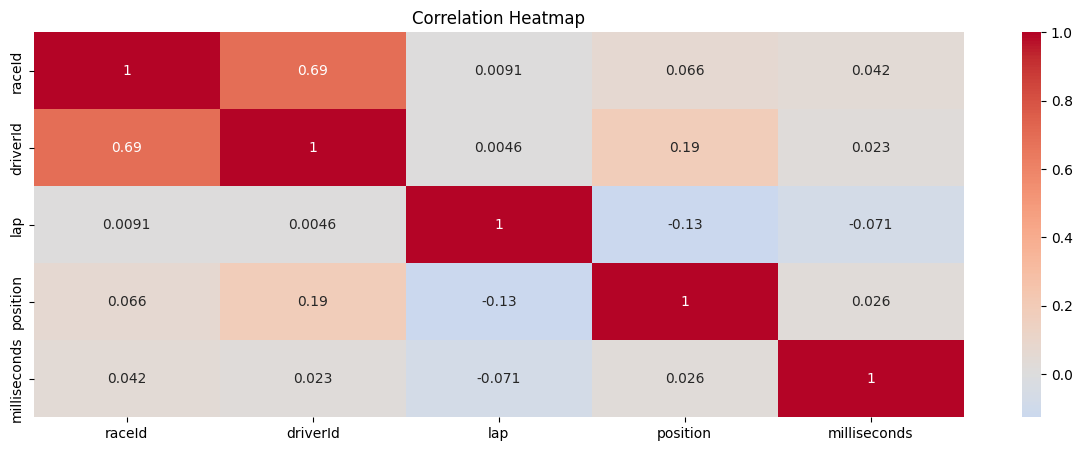

In [638]:
corr_matrix = lap_times[['raceId', 'driverId', 'lap', 'position', 'milliseconds']].corr()

# Plotting the heatmap
plt.figure(figsize=(15, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

In [639]:
 # There are 24 poistions overall
lap_times["position"].unique()

array([ 1,  3,  4,  2,  7,  8,  6,  5, 11, 12, 10,  9, 13, 16, 17, 15, 14,
       18, 19, 20, 21, 22, 24, 23])

Text(0.5, 1.0, 'Position vs. Time Taken to complete the race')

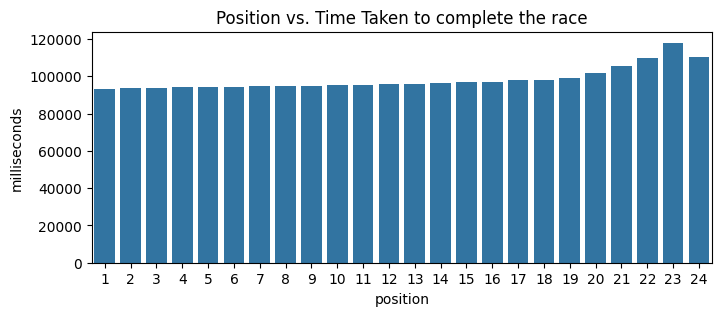

In [640]:
# As the position increases, the time taken also increases, slower the driver's overall time, higher is the position number value
plt.figure(figsize=(8, 3))
sns.barplot(x=lap_times["position"], y=lap_times["milliseconds"], errorbar=None)
plt.title("Position vs. Time Taken to complete the race")

**Notes**
* As we can see the number of milliseconds increases from the first to the last position as expected. 

#### pit_stops dataframe preprocessing

In [641]:
pit_stops.head()

,raceId,driverId,stop,lap,time,duration,milliseconds
0,841,153,1,1,17:05:23,26.898,26898
1,841,30,1,1,17:05:52,25.021,25021
2,841,17,1,11,17:20:48,23.426,23426
3,841,4,1,12,17:22:34,23.251,23251
4,841,13,1,13,17:24:10,23.842,23842


In [642]:
pit_stops.isna().sum()

raceId          0
driverId        0
stop            0
lap             0
time            0
duration        0
milliseconds    0
dtype: int64

In [643]:
pit_stops.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
raceId,10089.0,NaN,NaN,NaN,962.8,81.1,841.0,888.0,958.0,1035.0,1110.0
driverId,10089.0,NaN,NaN,NaN,524.0,389.7,1.0,18.0,815.0,831.0,858.0
stop,10089.0,NaN,NaN,NaN,1.8,0.9,1.0,1.0,2.0,2.0,6.0
lap,10089.0,NaN,NaN,NaN,25.3,14.7,1.0,13.0,25.0,36.0,78.0
time,10089,7492,14:22:38,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
duration,10089,6969,22.745,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
milliseconds,10089.0,NaN,NaN,NaN,75348.6,278858.8,12897.0,21914.0,23570.0,26202.0,3069017.0


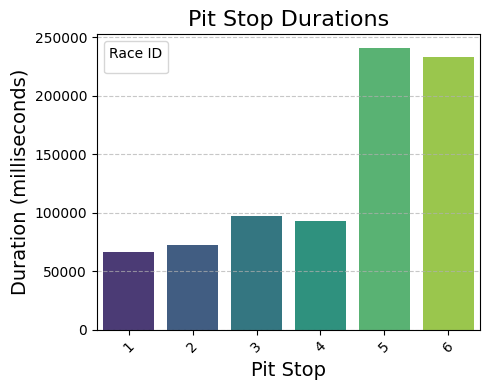

In [644]:
# Pit Stop Durations
plt.figure(figsize=(5, 4))
sns.barplot(x=pit_stops["stop"], y=pit_stops["milliseconds"], errorbar=None, palette='viridis')

plt.title('Pit Stop Durations', fontsize=16)
plt.xlabel('Pit Stop', fontsize=14)
plt.ylabel('Duration (milliseconds)', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Race ID')
plt.tight_layout()
plt.show()

**Notes:** *Maximum amount of time is spent on pit stop 5.*
 

#### qualifying dataframe preprocessing

In [645]:
qualifying.head()

,qualifyId,raceId,driverId,constructorId,number,position,q1,q2,q3
0,1,18,1,1,22,1,1:26.572,1:25.187,1:26.714
1,2,18,9,2,4,2,1:26.103,1:25.315,1:26.869
2,3,18,5,1,23,3,1:25.664,1:25.452,1:27.079
3,4,18,13,6,2,4,1:25.994,1:25.691,1:27.178
4,5,18,2,2,3,5,1:25.960,1:25.518,1:27.236


In [646]:
qualifying.isna().sum()

qualifyId           0
raceId              0
driverId            0
constructorId       0
number              0
position            0
q1                149
q2               4473
q3               6518
dtype: int64

In [647]:
qualifying.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
qualifyId,9815.0,NaN,NaN,NaN,4920.1,2847.6,1.0,2455.5,4910.0,7383.5,9872.0
raceId,9815.0,NaN,NaN,NaN,589.8,421.2,1.0,119.5,856.0,981.0,1110.0
driverId,9815.0,NaN,NaN,NaN,314.5,381.3,1.0,16.0,50.0,818.0,858.0
constructorId,9815.0,NaN,NaN,NaN,44.8,70.8,1.0,4.0,9.0,28.0,214.0
number,9815.0,NaN,NaN,NaN,18.1,17.9,0.0,7.0,14.0,22.0,99.0
position,9815.0,NaN,NaN,NaN,11.2,6.3,1.0,6.0,11.0,17.0,28.0
q1,9666,8620,1:20.888,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
q2,5342,5030,1:15.742,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
q3,3297,3179,1:45.503,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [648]:
# Handle Missing Values
qualifying["q1"].fillna("100:00.000", inplace=True)
qualifying["q2"].fillna("100:00.000", inplace=True)
qualifying["q3"].fillna("100:00.000", inplace=True)

qualifying['q1_datetime'] = qualifying['q1'].apply(time_to_datetime)
qualifying['q2_datetime'] = qualifying['q2'].apply(time_to_datetime)
qualifying['q3_datetime'] = qualifying['q3'].apply(time_to_datetime)


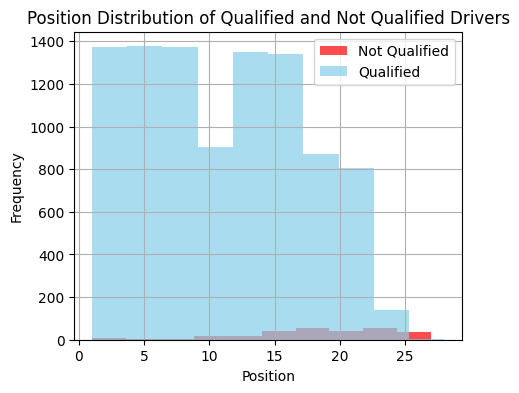

In [649]:
not_qualified_driverId = list(set(qualifying['driverId'].unique()) - set(lap_times['driverId'].unique()))
plt.figure(figsize=(5, 4))
qualifying["position"][qualifying['driverId'].isin(not_qualified_driverId)].hist(color='red', alpha=0.7, label='Not Qualified')
qualifying["position"][~qualifying['driverId'].isin(not_qualified_driverId)].hist(color='skyblue', alpha=0.7, label='Qualified')
plt.title('Position Distribution of Qualified and Not Qualified Drivers')
plt.xlabel('Position')
plt.ylabel('Frequency')
plt.legend()
plt.show()

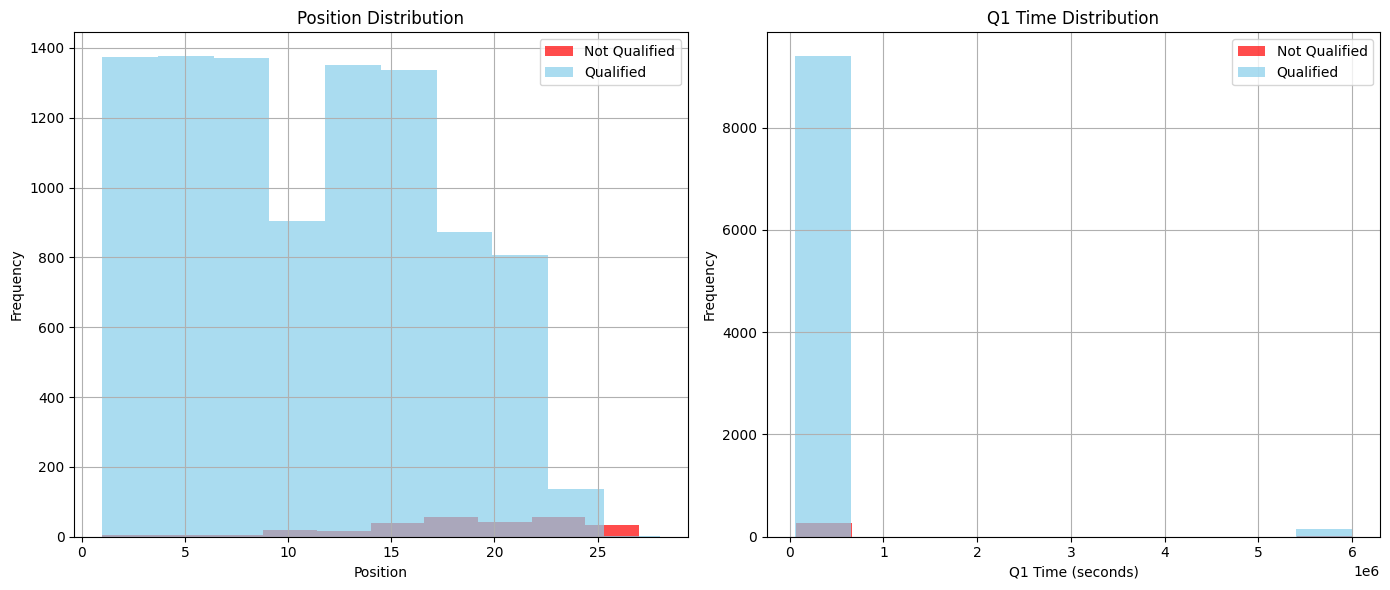

In [651]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Histogram for position
qualifying["position"][qualifying['driverId'].isin(not_qualified_driverId)].hist(
    color='red', alpha=0.7, label='Not Qualified', ax=axes[0], density=False)
qualifying["position"][~qualifying['driverId'].isin(not_qualified_driverId)].hist(
    color='skyblue', alpha=0.7, label='Qualified', ax=axes[0], density=False)
axes[0].set_title('Position Distribution')
axes[0].set_xlabel('Position')
axes[0].set_ylabel('Frequency')
axes[0].legend()

# Histogram for q1_datetime
qualifying["q1_datetime"][qualifying['driverId'].isin(not_qualified_driverId)].hist(
    color='red', alpha=0.7, label='Not Qualified', ax=axes[1], density=False)
qualifying["q1_datetime"][~qualifying['driverId'].isin(not_qualified_driverId)].hist(
    color='skyblue', alpha=0.7, label='Qualified', ax=axes[1], density=False)
axes[1].set_title('Q1 Time Distribution')
axes[1].set_xlabel('Q1 Time (seconds)')
axes[1].set_ylabel('Frequency')
axes[1].legend()

plt.tight_layout()
plt.show()


In [652]:
qualifying["position"][~qualifying['driverId'].isin(not_qualified_driverId)].nunique()

27

#### races dataframe preprocessing

In [653]:
races.head()

,raceId,year,round,circuitId,name,date,time,url,fp1_date,fp1_time,fp2_date,fp2_time,fp3_date,fp3_time,quali_date,quali_time,sprint_date,sprint_time
0,1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,http://en.wikipedia.org/wiki/2009_Australian_G...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2009,2,2,Malaysian Grand Prix,2009-04-05,09:00:00,http://en.wikipedia.org/wiki/2009_Malaysian_Gr...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2009,3,17,Chinese Grand Prix,2009-04-19,07:00:00,http://en.wikipedia.org/wiki/2009_Chinese_Gran...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2009,4,3,Bahrain Grand Prix,2009-04-26,12:00:00,http://en.wikipedia.org/wiki/2009_Bahrain_Gran...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2009,5,4,Spanish Grand Prix,2009-05-10,12:00:00,http://en.wikipedia.org/wiki/2009_Spanish_Gran...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [654]:
(races.isna().sum()/len(races))*100

raceId          0.0
year            0.0
round           0.0
circuitId       0.0
name            0.0
date            0.0
time           66.4
url             0.0
fp1_date       94.0
fp1_time       96.0
fp2_date       94.0
fp2_time       96.0
fp3_date       95.1
fp3_time       96.8
quali_date     94.0
quali_time     96.0
sprint_date    98.9
sprint_time    99.2
dtype: float64

In [655]:
# All of these columns have more than 95% of values as missing values - it's better to drop them in these cases
races.drop(columns=['fp1_date', 'fp1_time', 'fp2_date', 'fp2_time', 'fp3_date', 'fp3_time', 'quali_date', 'quali_time', 'sprint_date', 'sprint_time'], inplace=True)

In [656]:
# All of these columns have more than 60% of values as missing values - it's better to drop them in these cases
races.drop(columns=['time'], inplace=True)

In [657]:
races.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
raceId,1101.0,NaN,NaN,NaN,553.4,321.4,1.0,276.0,551.0,826.0,1120.0
year,1101.0,NaN,NaN,NaN,1992.0,20.3,1950.0,1976.0,1994.0,2010.0,2023.0
round,1101.0,NaN,NaN,NaN,8.5,5.1,1.0,4.0,8.0,12.0,22.0
circuitId,1101.0,NaN,NaN,NaN,23.7,19.3,1.0,9.0,18.0,34.0,80.0
name,1101,54,Italian Grand Prix,74,NaN,NaN,NaN,NaN,NaN,NaN,NaN
date,1101,1101,2009-03-29,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
url,1101,1101,http://en.wikipedia.org/wiki/2009_Australian_G...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [658]:
races["name"][(races["year"]>=2014) & (races["year"]<=2023)].value_counts(normalize=True).head(10)*100

Bahrain Grand Prix          4.9
Spanish Grand Prix          4.9
Austrian Grand Prix         4.9
British Grand Prix          4.9
Abu Dhabi Grand Prix        4.9
Hungarian Grand Prix        4.9
Belgian Grand Prix          4.9
Italian Grand Prix          4.9
United States Grand Prix    4.4
Monaco Grand Prix           4.4
Name: name, dtype: float64

#### status dataframe preprocessing

In [659]:
status.head()

,statusId,status
0,1,Finished
1,2,Disqualified
2,3,Accident
3,4,Collision
4,5,Engine


In [660]:
status.isna().sum()

statusId    0
status      0
dtype: int64

In [661]:
status.describe(include='all')

,statusId,status
count,139.0,139
unique,NaN,139
top,NaN,Finished
freq,NaN,1
mean,71.2,NaN
std,41.1,NaN
min,1.0,NaN
25%,35.5,NaN
50%,72.0,NaN
75%,106.5,NaN


#### sprint_results dataframe preprocessing

In [662]:
sprint_results.head()

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,fastestLapTime,statusId
0,1,1061,830,9,33,2,1,1,1,3,17,25:38.426,1538426,14,1:30.013,1
1,2,1061,1,131,44,1,2,2,2,2,17,+1.430,1539856,17,1:29.937,1
2,3,1061,822,131,77,3,3,3,3,1,17,+7.502,1545928,17,1:29.958,1
3,4,1061,844,6,16,4,4,4,4,0,17,+11.278,1549704,16,1:30.163,1
4,5,1061,846,1,4,6,5,5,5,0,17,+24.111,1562537,16,1:30.566,1


In [663]:
sprint_results.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
resultId,180.0,NaN,NaN,NaN,90.5,52.1,1.0,45.8,90.5,135.2,180.0
raceId,180.0,NaN,NaN,NaN,1085.7,17.4,1061.0,1071.0,1084.0,1101.0,1110.0
driverId,180.0,NaN,NaN,NaN,714.1,298.1,1.0,817.0,840.0,847.0,858.0
constructorId,180.0,NaN,NaN,NaN,95.5,88.4,1.0,6.0,84.0,210.0,214.0
number,180.0,NaN,NaN,NaN,27.6,24.3,1.0,10.0,20.0,44.0,99.0
grid,180.0,NaN,NaN,NaN,10.1,5.9,0.0,5.0,10.0,15.0,20.0
position,171,20,1,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
positionText,180,23,1,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
positionOrder,180.0,NaN,NaN,NaN,10.5,5.8,1.0,5.8,10.5,15.2,20.0
points,180.0,NaN,NaN,NaN,1.3,2.3,0.0,0.0,0.0,2.0,8.0


In [664]:
# The cases where position/time/ms/fastestLap/fastestLapTime are missing, the status is 'Not Finished'
(sprint_results.isna().sum()/len(sprint_results))*100

resultId          0.0
raceId            0.0
driverId          0.0
constructorId     0.0
number            0.0
grid              0.0
position          5.0
positionText      0.0
positionOrder     0.0
points            0.0
laps              0.0
time              5.6
milliseconds      5.6
fastestLap        3.3
fastestLapTime    3.3
statusId          0.0
dtype: float64

##### **NOTE:**
- In all these missing value cases, missing value means an Unfinished race. Therefore, these missing values need to be filled with caution. 

In [665]:
sprint_results["positionText"].unique()

array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', 'R', '20', 'N', 'W'],
      dtype=object)

In [666]:
sprint_results[sprint_results["positionText"].isin(["R", "W", "N"])]

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,fastestLapTime,statusId
19,20,1061,815,9,11,5,NaN,R,20,0,16,NaN,NaN,6,1:31.465,76
39,40,1065,842,213,10,6,NaN,R,20,0,0,NaN,NaN,NaN,NaN,3
79,80,1077,855,51,24,0,NaN,R,20,0,0,NaN,NaN,NaN,NaN,31
99,100,1084,4,214,14,8,NaN,N,20,0,0,NaN,NaN,NaN,NaN,10
119,120,1095,848,3,23,11,NaN,R,20,0,12,NaN,NaN,4,1:15.998,31
138,139,1101,852,213,22,16,NaN,R,19,0,2,NaN,NaN,NaN,NaN,130
139,140,1101,858,3,2,0,NaN,W,20,0,0,NaN,NaN,NaN,NaN,3
178,179,1110,815,9,11,8,NaN,R,19,0,8,NaN,NaN,2,2:02.516,130
179,180,1110,4,117,14,15,NaN,R,20,0,2,NaN,NaN,NaN,NaN,3


In [667]:
# Handle missing values

sprint_results["position"] = sprint_results["position"].fillna(0)
sprint_results["time"] = sprint_results["time"].fillna("-1.00")
sprint_results["milliseconds"] = sprint_results["milliseconds"].fillna(0)
sprint_results["fastestLapTime"] = sprint_results["fastestLapTime"].fillna("00.00.000")
sprint_results["fastestLap"] = sprint_results["fastestLap"].fillna(0) #number of laps is zero for these so fastestLap will by default be 0

#### results dataframe preprocessing

In [668]:
results.head()

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
0,1,18,1,1,22,1,1,1,1,10.0,58,1:34:50.616,5690616,39,2,1:27.452,218.300,1
1,2,18,2,2,3,5,2,2,2,8.0,58,+5.478,5696094,41,3,1:27.739,217.586,1
2,3,18,3,3,7,7,3,3,3,6.0,58,+8.163,5698779,41,5,1:28.090,216.719,1
3,4,18,4,4,5,11,4,4,4,5.0,58,+17.181,5707797,58,7,1:28.603,215.464,1
4,5,18,5,1,23,3,5,5,5,4.0,58,+18.014,5708630,43,1,1:27.418,218.385,1


In [669]:
results.isna().sum(), len(results)

(resultId               0
 raceId                 0
 driverId               0
 constructorId          0
 number                 6
 grid                   0
 position           10873
 positionText           0
 positionOrder          0
 points                 0
 laps                   0
 time               18829
 milliseconds       18830
 fastestLap         18465
 rank               18249
 fastestLapTime     18465
 fastestLapSpeed    18465
 statusId               0
 dtype: int64,
 26080)

In [670]:
# Handle columns with over 70% missing values
results.drop(columns=['time', 'milliseconds', 'fastestLap', 'rank', 'fastestLapTime', 'fastestLapSpeed'], inplace=True)

In [671]:
results = results.merge(status, how="left", on="statusId")

<Figure size 1400x800 with 0 Axes>

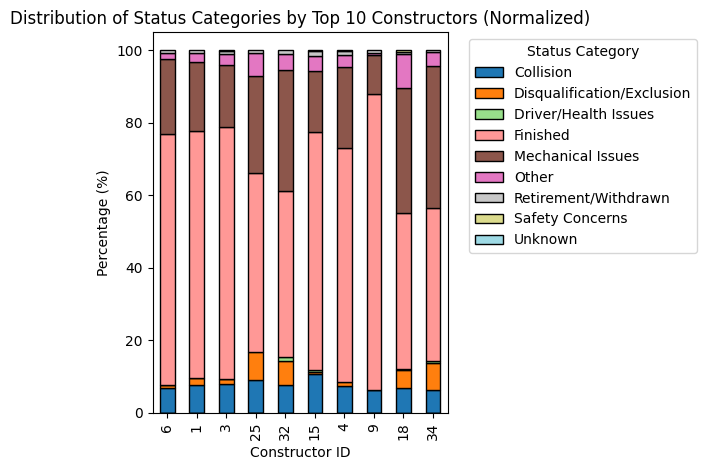

In [672]:
categories = {
    'Finished': [
        'Finished', '+1 Lap', '+2 Laps', '+3 Laps', '+4 Laps', '+5 Laps',
        '+6 Laps', '+7 Laps', '+8 Laps', '+9 Laps', '+10 Laps', '+11 Laps',
        '+12 Laps', '+13 Laps', '+14 Laps', '+15 Laps', '+16 Laps', '+17 Laps',
        '+18 Laps', '+19 Laps', '+20 Laps', '+21 Laps', '+22 Laps', '+23 Laps',
        '+24 Laps', '+25 Laps', '+26 Laps', '+29 Laps', '+30 Laps', '+42 Laps',
        '+44 Laps', '+46 Laps'
    ],
    'Collision': [
        'Collision', 'Accident', 'Collision damage', 'Debris'
    ],
    'Mechanical Issues': [
        'Engine', 'Transmission', 'Clutch', 'Electrical', 'Hydraulics',
        'Gearbox', 'Radiator', 'Suspension', 'Brakes', 'Overheating',
        'Mechanical', 'Tyre', 'Puncture', 'Driveshaft', 'Fuel pressure',
        'Water pressure', 'Refuelling', 'Wheel', 'Throttle', 'Steering',
        'Technical', 'Electronics', 'Broken wing', 'Heat shield fire',
        'Exhaust', 'Oil leak', 'Wheel rim', 'Water leak', 'Fuel pump',
        'Track rod', 'Oil pressure', 'Pneumatics', 'Engine fire', 'Tyre puncture',
        'Out of fuel', 'Wheel nut', 'Handling', 'Rear wing', 'Fire',
        'Fuel system', 'Oil line', 'Fuel rig', 'Launch control', 'Fuel',
        'Power loss', 'Drivetrain', 'Ignition', 'Chassis', 'Battery',
        'Stalled', 'Halfshaft', 'Crankshaft', 'Alternator', 'Differential',
        'Wheel bearing', 'Oil pump', 'Fuel leak', 'Injection', 'Distributor',
        'Turbo', 'CV joint', 'Water pump', 'Spark plugs', 'Fuel pipe',
        'Oil pipe', 'Axle', 'Water pipe', 'Magneto', 'Supercharger',
        'Engine misfire', 'ERS', 'Power Unit', 'Brake duct', 'Seat',
        'Damage', 'Cooling system', 'Undertray'
    ],
    'Driver/Health Issues': [
        'Driver Seat', 'Driver unwell', 'Injured', 'Injury', 'Physical',
        'Eye injury', 'Illness', 'Fatal accident'
    ],
    'Disqualification/Exclusion': [
        'Disqualified', 'Not classified', '107% Rule', 'Did not qualify',
        'Did not prequalify', 'Excluded', 'Underweight'
    ],
    'Retirement/Withdrawn': [
        'Retired', 'Withdrew', 'Not restarted'
    ],
    'Safety Concerns': [
        'Safety', 'Safety concerns', 'Safety belt'
    ],
    'Other': [
        'Spun off', 'Vibrations', 'Magneto'
    ]
}

# results['finished'] = results['status'].apply(lambda x: 'Finished' if x in categories['Finished'] else 'Not Finished')

def categorize_status(status):
    for category, statuses in categories.items():
        if status in statuses:
            return category
    return 'Unknown'  # For any status not in the predefined categories

results['category'] = results['status'].apply(categorize_status)

# Top 10 teams across races have a higher percentage of 'Finished' status across races with mechanical issues being the top reason for 'Unfinished' races
grouped_data = results.groupby('constructorId')['category'].value_counts(normalize=True).mul(100).unstack()
top_constructors = results['constructorId'].value_counts().head(10).index
grouped_data = grouped_data.loc[top_constructors]

plt.figure(figsize=(14, 8))
grouped_data.plot(kind='bar', stacked=True, colormap='tab20', edgecolor='black')
plt.title('Distribution of Status Categories by Top 10 Constructors (Normalized)')
plt.xlabel('Constructor ID')
plt.ylabel('Percentage (%)')
plt.legend(title='Status Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [673]:
def podium(styler, caption=""):
    styler.set_caption("Results")
    styler.background_gradient(axis=None, vmin=1, vmax=5, cmap="YlGnBu")
    styler.hide(axis='index')
    return styler
    
results[['driverId', 'grid', 'position', 'positionText', 'points', 'status']].iloc[:10].style.pipe(podium)


driverId,grid,position,positionText,points,status
1,1,1,1,10.000000,Finished
2,5,2,2,8.000000,Finished
3,7,3,3,6.000000,Finished
4,11,4,4,5.000000,Finished
5,3,5,5,4.000000,Finished
6,13,6,6,3.000000,+1 Lap
7,17,7,7,2.000000,Engine
8,15,8,8,1.000000,Engine
9,2,nan,R,0.000000,Collision
10,18,nan,R,0.000000,Accident


#### **DataFrame Merging**

In [674]:
merged_df = pd.DataFrame()
merged_df = results.merge(races, on="raceId", how="left")
merged_df = merged_df.merge(lap_times, on=["raceId", "driverId"], suffixes=["", "_lap"])
merged_df = merged_df.merge(qualifying, on=["raceId", "driverId"], suffixes=["", "_qualify"])
merged_df = merged_df.merge(pit_stops, on=["raceId", "driverId"], suffixes=["", "_pitstops"])

In [675]:
len(merged_df["resultId"].unique()) & len(sprint_results["resultId"].unique())

36

In [676]:
merged_df.isna().sum()

resultId                     0
raceId                       0
driverId                     0
constructorId                0
number                       0
grid                         0
position                 31679
positionText                 0
positionOrder                0
points                       0
laps                         0
statusId                     0
status                       0
category                     0
year                         0
round                        0
circuitId                    0
name                         0
date                         0
url                          0
lap                          0
position_lap                 0
time                         0
milliseconds                 0
is_top_10_driver             0
qualifyId                    0
constructorId_qualify        0
number_qualify               0
position_qualify             0
q1                           0
q2                           0
q3                           0
q1_datet

In [677]:
 # In merged dataframe, only the position column has missing values
 # This is due to the driver not completing the race due to Accident/Retired/Withdrawn etc.
merged_df[merged_df["position"].isna()==True]["positionText"].unique()

array(['N', 'R', 'D', 'E'], dtype=object)

In [678]:
merged_df["position_lap"] = merged_df["position_lap"].astype(int)
merged_df["position"] = merged_df["position"].fillna(0).astype(int)
merged_df["number"] = merged_df["number"].astype(int)

In [679]:
merged_df = merged_df[['resultId', 'raceId', 'driverId', 'constructorId', 'number', 'grid',
       'position', 'positionText', 'points', 'laps',
       'statusId', 'status', 'category', 'year', 'round', 'circuitId', 'name',
       'date', 'url', 'lap', 'position_lap', 'milliseconds',
       'is_top_10_driver', 'position_qualify', 'stop', 'lap_pitstops', 'milliseconds_pitstops']]

#### **Filtering by driverId & event**

In [680]:
event_df = merged_df[merged_df["name"]=='Monaco Grand Prix']
event_df = event_df[event_df["year"].isin(list(range(2014, 2024)))]

In [681]:
event_df["driverId"].value_counts(normalize=True).head()*100

815    6.7
1      5.2
822    4.7
830    4.2
840    4.1
Name: driverId, dtype: float64

In [778]:
def driverid_df_processing(driver_id):
    driverid_df = event_df[event_df["driverId"]==driver_id]
    total_stops = driverid_df.groupby("raceId")["stop"].sum().reset_index()
    total_stops.rename(columns={"stop": "total_stops"}, inplace=True)
    driverid_df = driverid_df.merge(total_stops, on="raceId", how="left")
    driverid_df = driverid_df[['resultId', 'raceId', 'constructorId', 'grid',
        'position', 'positionText', 'points', 'laps', 'status', 'category', 'year', 'round',
        'date', 'lap', 'position_lap', 'milliseconds', 'is_top_10_driver', 'position_qualify', 'total_stops', 'milliseconds_pitstops']]

    # Lag features
    driverid_df['last_lap_time'] = driverid_df['milliseconds'].shift(1)

    # Rolling averages
    driverid_df['avg_last_3_laps'] = driverid_df['milliseconds'].rolling(window=3).mean()

    corr_matrix = driverid_df[['milliseconds', 'resultId', 'raceId', 'grid', 'position', 'positionText', 'points', 
    'laps', 'status', 'year', 'round', 'lap', 'position_lap', 'position_qualify', 
    'milliseconds_pitstops', 'total_stops']].corr()

    # Plotting the heatmap
    plt.figure(figsize=(15, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation Heatmap')
    plt.show() 

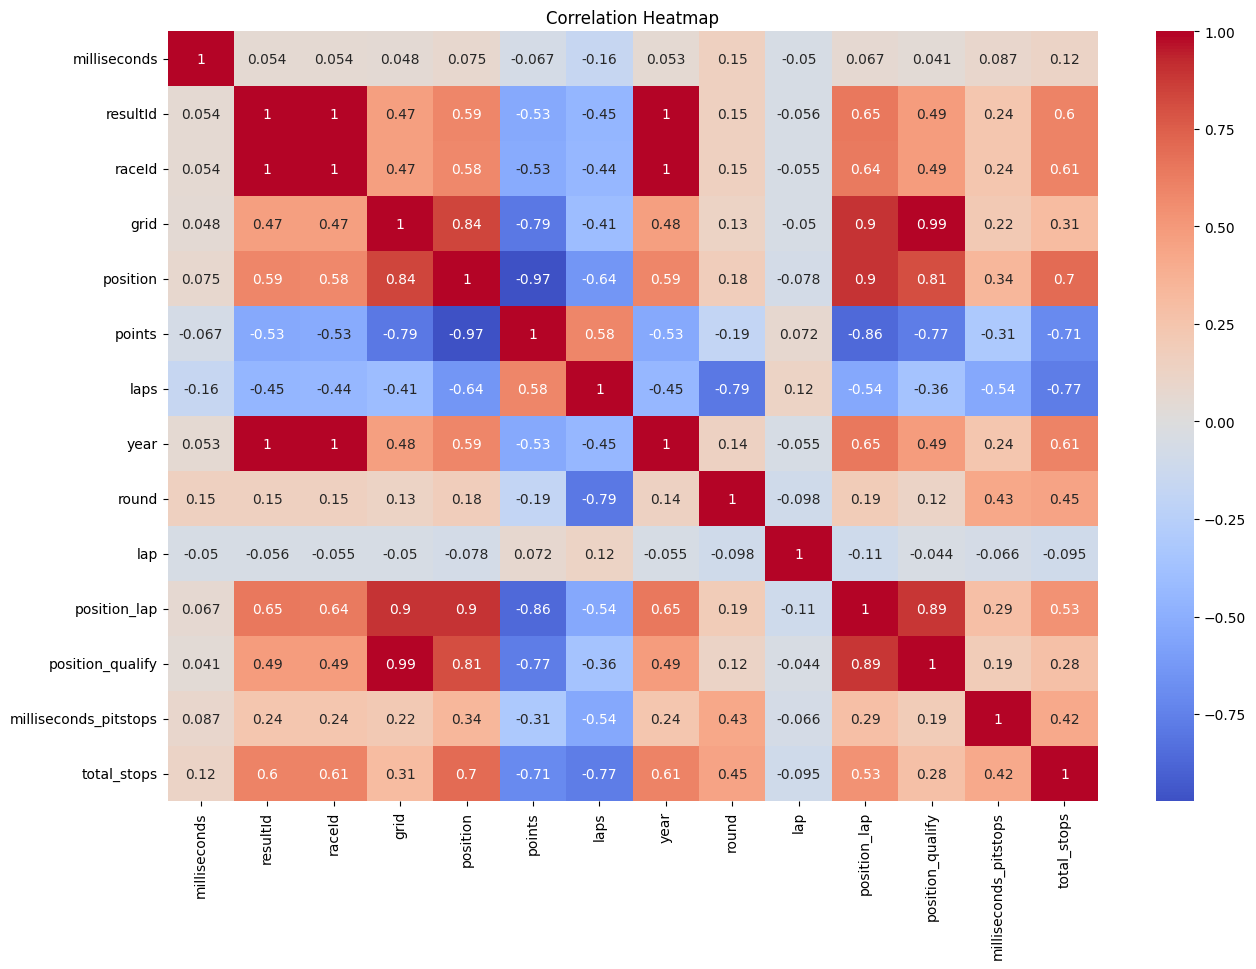

In [779]:
driverid_df_processing(1)

In [780]:
# all races have ~78 laps
driverid_df.groupby("raceId")["lap"].unique().apply(lambda x: (min(x), max(x)))

raceId
905     (1, 55)
931     (1, 78)
953     (1, 77)
974     (1, 78)
994     (1, 78)
1015    (1, 78)
1080    (1, 64)
1104    (1, 77)
Name: lap, dtype: object

**Summary of Correlations with milliseconds**

1. **Weak Positive Correlations:**
    - position: 0.075 — Suggests that higher starting positions correlate with slightly faster lap times.
    - grid: 0.048 — Indicates a weak positive correlation with starting grid position.

2. **Weak Negative Correlations:**
    - points: -0.067 — Drivers who earn more points (indicative of better race performance) tend to have slower lap times.
    - laps: -0.160 — More laps completed may correlate with longer lap times, possibly due to fatigue or race strategy.

3. **Other Notable Correlations:**
    - total_stops: 0.121 — Indicates that more pit stops could be associated with longer lap times, possibly due to time lost during stops.
    - milliseconds_pitstops: 0.087 — Longer pit stop durations may contribute to slower overall lap times.

4. **Strong Correlations with Other Variables:**
    - resultId, raceId, year: Generally high correlations (around 0.5-1.0) with other identifiers but not with lap times directly.
    - position_qualify: 0.041 — Suggests a weak link between qualifying position and lap times.

5. **Implications**
    - Lap Performance: The positive correlation between grid and position with milliseconds suggests that starting higher can lead to better lap times.
    - Pit Strategy: The correlation with total stops and pit stop durations indicates that race strategy and execution significantly impact overall performance.
    This summary helps identify which features may influence lap times and guide further analysis or feature engineering for forecasting models.








#### **Forecasting Model Training**

In [781]:
def forecast_model(driverid_df):
    train_data = driverid_df[driverid_df['year'] < 2023]
    test_data = driverid_df[driverid_df['year'] == 2023]

    X_train = train_data[['lap', 'grid', 'position', 'avg_last_3_laps', 'last_lap_time', 
                        'milliseconds_pitstops', 'total_stops', 'position_qualify']]
    y_train = train_data['milliseconds']

    X_test = test_data[['lap', 'grid', 'position', 'avg_last_3_laps', 'last_lap_time', 
                        'milliseconds_pitstops', 'total_stops', 'position_qualify']]
    y_test = test_data['milliseconds']

    model = XGBRegressor(objective='reg:squarederror')
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    print(f'RMSE: {rmse}, MAE: {mae}')

    plt.figure(figsize=(12, 6))
    plt.plot(y_test.reset_index(drop=True), label='Actual Lap Times', color='blue')
    plt.plot(y_pred, label='Predicted Lap Times', color='orange')
    plt.title('Actual vs Predicted Lap Times')
    plt.xlabel('Lap Count')
    plt.ylabel('Lap Time (milliseconds)')
    plt.legend()
    plt.show()
    return X_train, model


RMSE: 4047.8873275305564, MAE: 2235.1227678571427


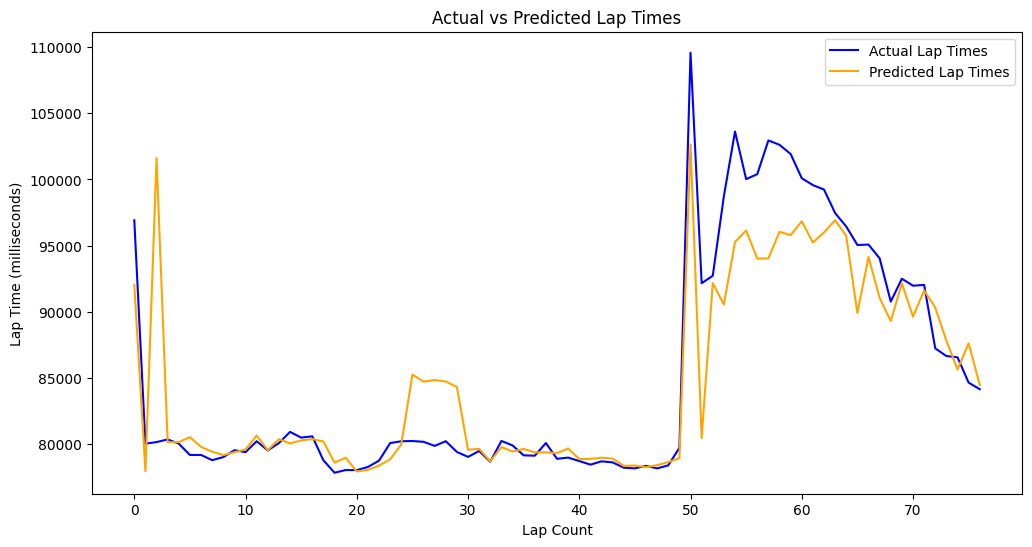

In [782]:
X_train_1, model_1 = forecast_model(driverid_df)

In [783]:
# Save the model to a file
joblib.dump(model, 'lap_time_forecasting_model.joblib')

['lap_time_forecasting_model.joblib']

In [784]:
def get_feature_importances(X_train, model):
    importance = model.feature_importances_

    feature_names = X_train.columns  # Assuming X_train is a DataFrame
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})

    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # Plot the feature importances
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
    plt.xlabel('Importance Score')
    plt.title('Feature Importance from XGBoost')
    plt.show()

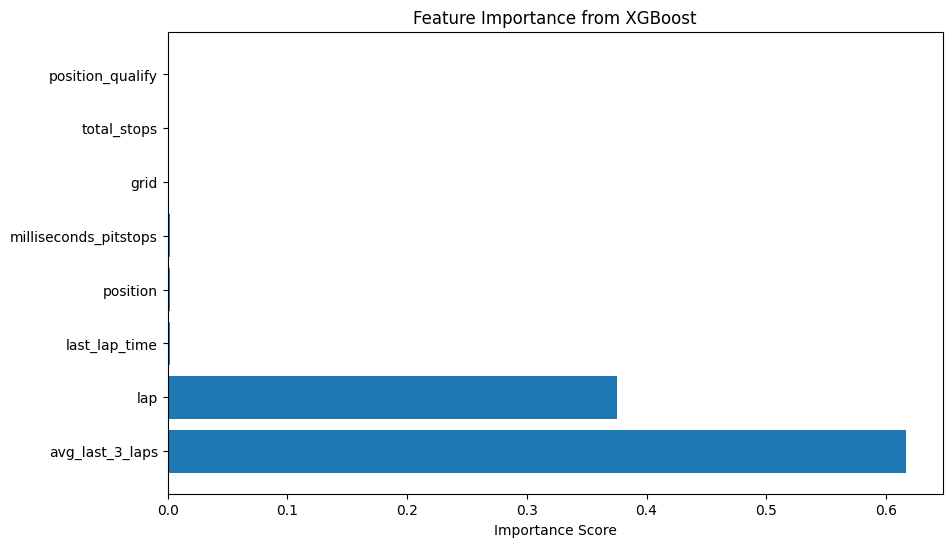

In [785]:
get_feature_importances(X_train_1, model_1)

### Bonus Question

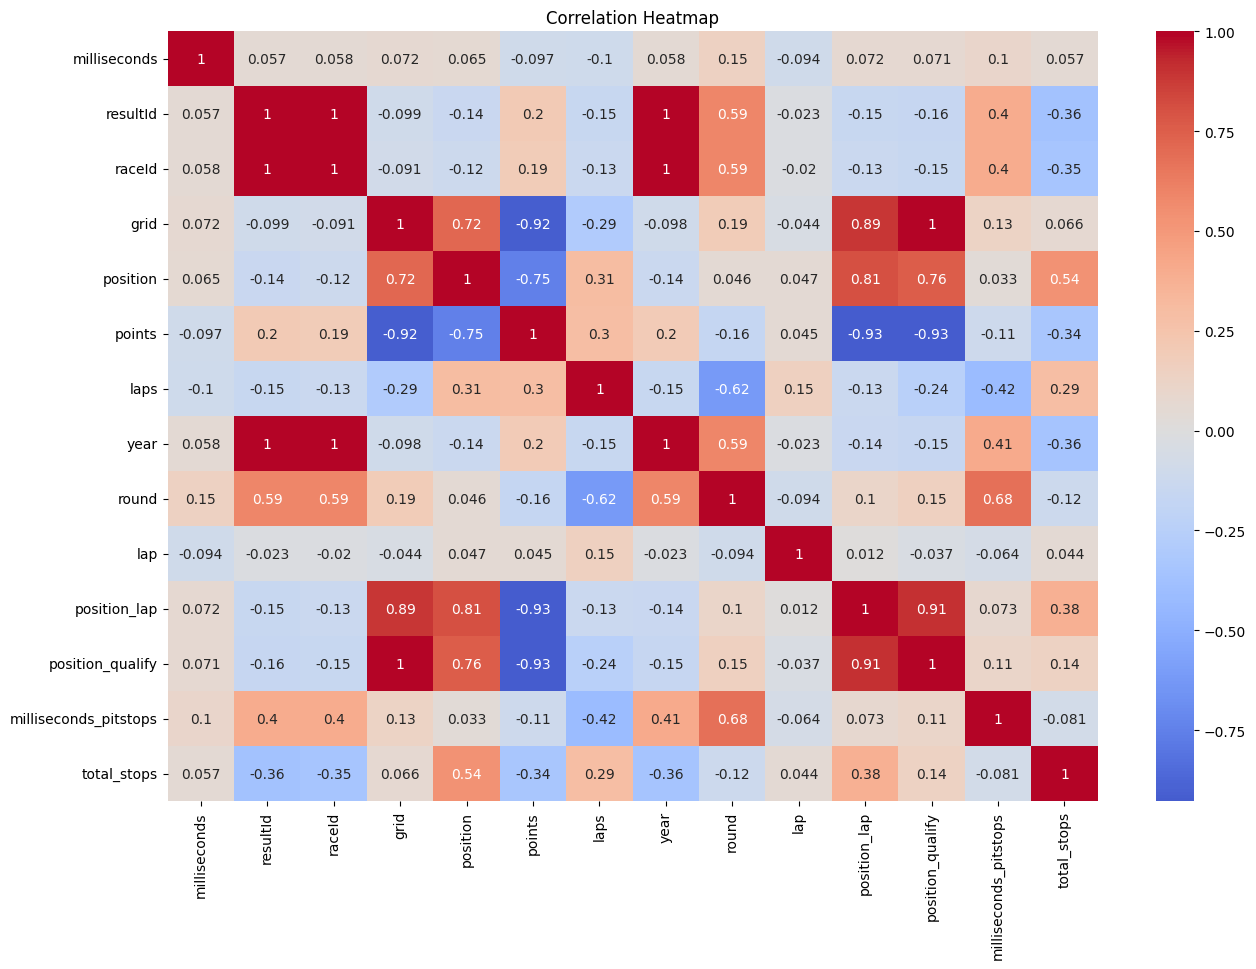

In [786]:
driverid_df_processing(822)

RMSE: 4047.8873275305564, MAE: 2235.1227678571427


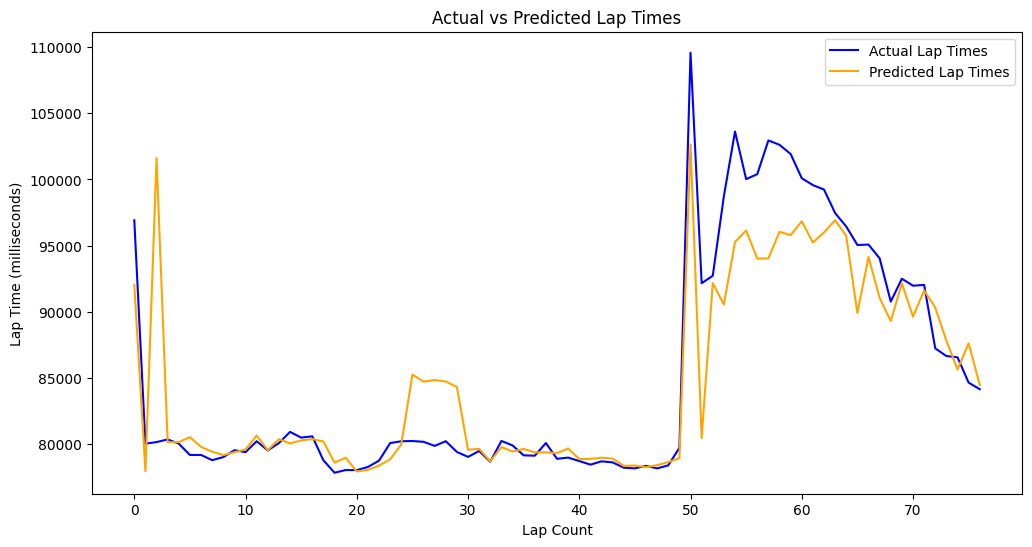

In [787]:
X_train_822, model_822 = forecast_model(driverid_df)

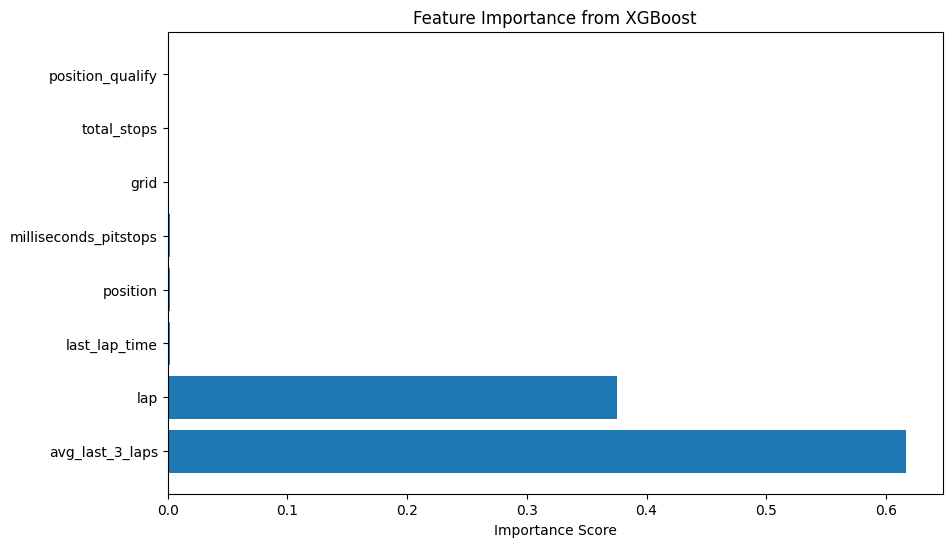

In [788]:
get_feature_importances(X_train_822, model_822)